In [ ]:
# !unzip data.zip

In [1]:
# 기본 라이브러리
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import warnings

warnings.filterwarnings('ignore')

# PyTorch 및 Torchvision 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torchsummary import summary

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')

In [6]:
# --- 경로 및 하이퍼파라미터 설정 ---

# 데이터 경로 (Colab 환경이나 로컬 환경에 맞게 수정하세요)
# 예시: './data/Plant seedling classification/'
DATA_PATH = '/content/Rice Image Dataset/'
TRAIN_DIR = os.path.join(DATA_PATH)

# PyTorch 학습을 위한 장치 설정 (GPU 우선 사용)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# 하이퍼파라미터
BATCH_SIZE = 64
IMG_SIZE = 128
EPOCHS = 30 # 에포크 수를 조정하여 학습 시간을 단축하거나 성능을 높일 수 있습니다.
LEARNING_RATE = 0.001

Using device: cuda


In [29]:
# 학습 데이터에 포함된 클래스(품종) 목록 확인
classes = sorted(os.listdir(TRAIN_DIR))
num_classes = len(classes)
print(f"클래스 목록: {classes}")
print(f"총 클래스 개수: {num_classes}")

# 모든 이미지 파일 경로와 해당 레이블(클래스 이름)을 리스트에 저장
all_image_paths = []
all_labels = []
for class_name in classes:
    class_dir = os.path.join(TRAIN_DIR, class_name)
    image_paths = glob(os.path.join(class_dir, '*.jpg'))
    all_image_paths.extend(image_paths)
    all_labels.extend([class_name] * len(image_paths))

클래스 목록: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag', 'Rice_Citation_Request.txt']
총 클래스 개수: 6


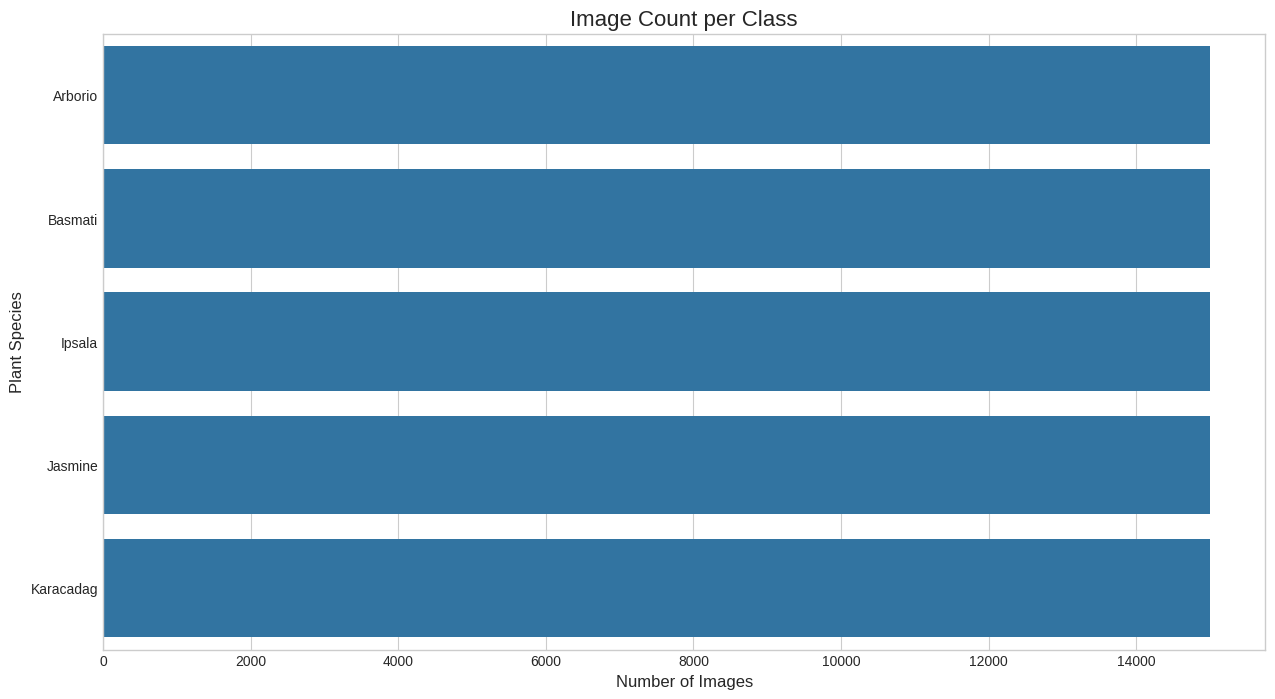

In [10]:
# 클래스별 이미지 개수 시각화
plt.figure(figsize=(15, 8))
sns.countplot(y=all_labels, order=pd.Series(all_labels).value_counts().index)
plt.title('Image Count per Class', fontsize=16)
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Plant Species', fontsize=12)
plt.show()

In [13]:
# 학습 데이터에 포함된 클래스(품종) 목록 확인
classes = sorted(os.listdir(TRAIN_DIR)) # <--- 문제 발생 가능 지점
num_classes = len(classes)
print(f"클래스 목록: {classes}")
print(f"총 클래스 개수: {num_classes}")

클래스 목록: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag', 'Rice_Citation_Request.txt']
총 클래스 개수: 6


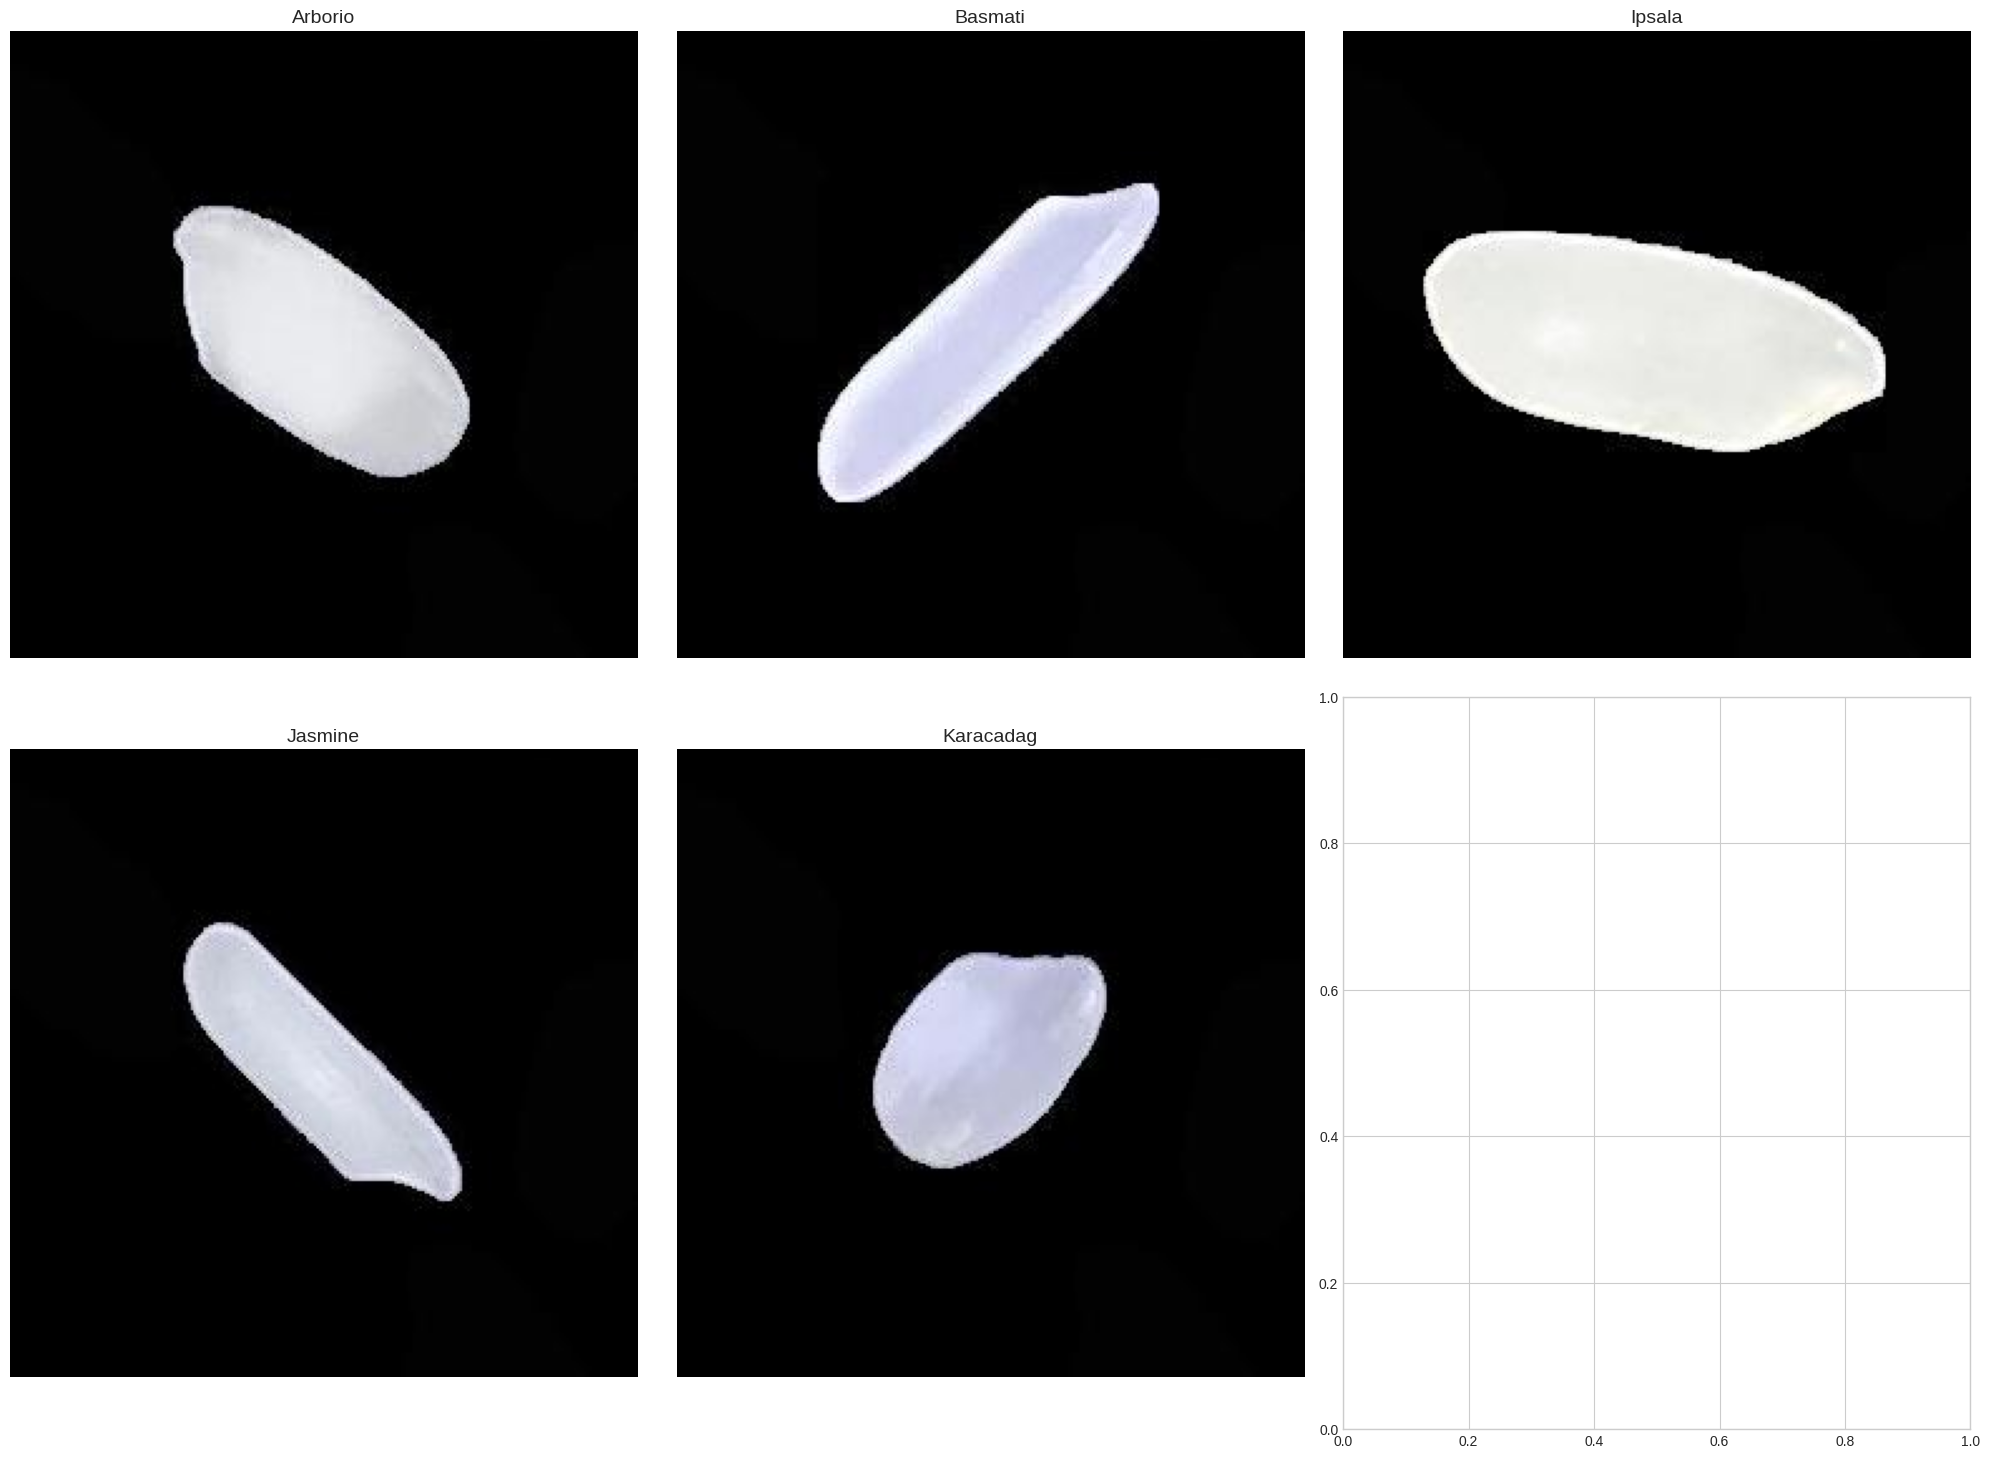

In [15]:
# 각 클래스별 샘플 이미지 시각화
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
axes = axes.flatten()

for i, class_name in enumerate(classes):
    if class_name =='Rice_Citation_Request.txt':
        continue
    # 각 클래스 디렉토리에서 첫 번째 이미지 경로 가져오기
    sample_image_path = glob(os.path.join(TRAIN_DIR, class_name, '*.jpg'))[0]
    img = Image.open(sample_image_path)

    ax = axes[i]
    ax.imshow(img)
    ax.set_title(class_name, fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [16]:
# 학습 데이터를 위한 변환 (데이터 증강 포함)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 검증 데이터를 위한 변환 (데이터 증강 없음)
valid_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [17]:
# 클래스 이름을 정수 인덱스로 변환하는 딕셔너리 생성
class_to_idx = {name: i for i, name in enumerate(classes)}
idx_to_class = {i: name for i, name in enumerate(classes)}

# 전체 데이터를 학습용과 검증용으로 분리
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)


class PlantSeedlingDataset(Dataset):
    def __init__(self, image_paths, labels, class_to_idx, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label_name = self.labels[idx]
        label_idx = self.class_to_idx[label_name]

        if self.transform:
            image = self.transform(image)

        return image, label_idx

# Dataset 인스턴스 생성
train_dataset = PlantSeedlingDataset(train_paths, train_labels, class_to_idx, transform=train_transforms)
valid_dataset = PlantSeedlingDataset(valid_paths, valid_labels, class_to_idx, transform=valid_transforms)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training data batches: {len(train_loader)}")
print(f"Validation data batches: {len(valid_loader)}")

Training data batches: 938
Validation data batches: 235


In [18]:
class PlantSeedlingCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantSeedlingCNN, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2) # 128x128 -> 64x64
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2) # 64x64 -> 32x32
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2) # 32x32 -> 16x16
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

# 모델 인스턴스 생성 및 장치로 이동
model = PlantSeedlingCNN(num_classes).to(device)

# 모델 구조 확인
summary(model, input_size=(3, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
       BatchNorm2d-3         [-1, 32, 128, 128]              64
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
              ReLU-6           [-1, 64, 64, 64]               0
       BatchNorm2d-7           [-1, 64, 64, 64]             128
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
             ReLU-10          [-1, 128, 32, 32]               0
      BatchNorm2d-11          [-1, 128, 32, 32]             256
        MaxPool2d-12          [-1, 128, 16, 16]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                  [

In [19]:
# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [20]:
# 모델 학습을 위한 루프 실행
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = train_loss / total_train
    train_accuracy = 100 * correct_train / total_train
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)

    # --- Validation Phase ---
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / total_val
    val_accuracy = 100 * correct_val / total_val
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

print("\nTraining finished.")

Epoch [1/30], Train Loss: 0.1788, Train Acc: 96.58%, Val Loss: 0.1800, Val Acc: 95.59%
Epoch [2/30], Train Loss: 0.0712, Train Acc: 98.31%, Val Loss: 0.1177, Val Acc: 97.01%


KeyboardInterrupt: 

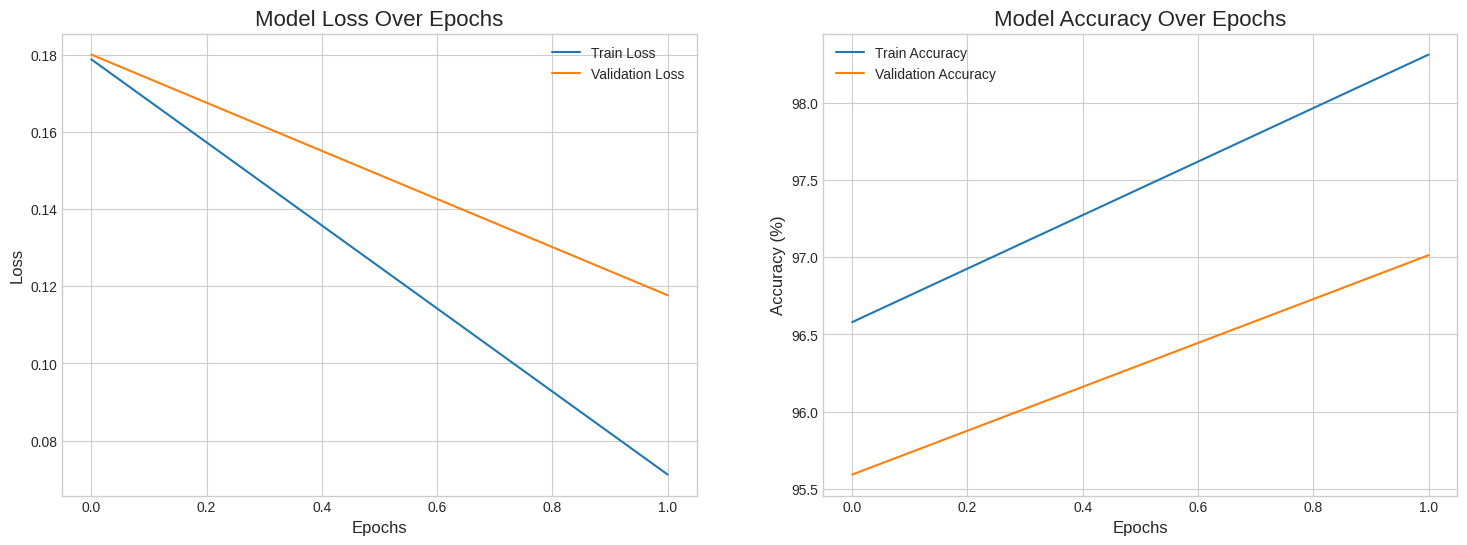

In [21]:
# 학습 과정의 손실 및 정확도 변화 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss Over Epochs', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.set_title('Model Accuracy Over Epochs', fontsize=16)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.legend()

plt.show()

In [24]:
# 검증 데이터셋에 대한 예측 수행
model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, y_pred = torch.max(outputs, 1)
        y_pred_list.extend(y_pred.cpu().numpy())
        y_true_list.extend(labels.cpu().numpy())

In [26]:
# Classification Report 출력 (정밀도, 재현율, F1-score)
classes = classes[:5]
print("Classification Report:\n")
print(classification_report(y_true_list, y_pred_list, target_names=classes))

Classification Report:

              precision    recall  f1-score   support

     Arborio       1.00      0.75      0.86      3000
     Basmati       0.89      1.00      0.94      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       0.97      0.87      0.92      3000
   Karacadag       0.82      1.00      0.90      3000

    accuracy                           0.92     15000
   macro avg       0.93      0.92      0.92     15000
weighted avg       0.93      0.92      0.92     15000



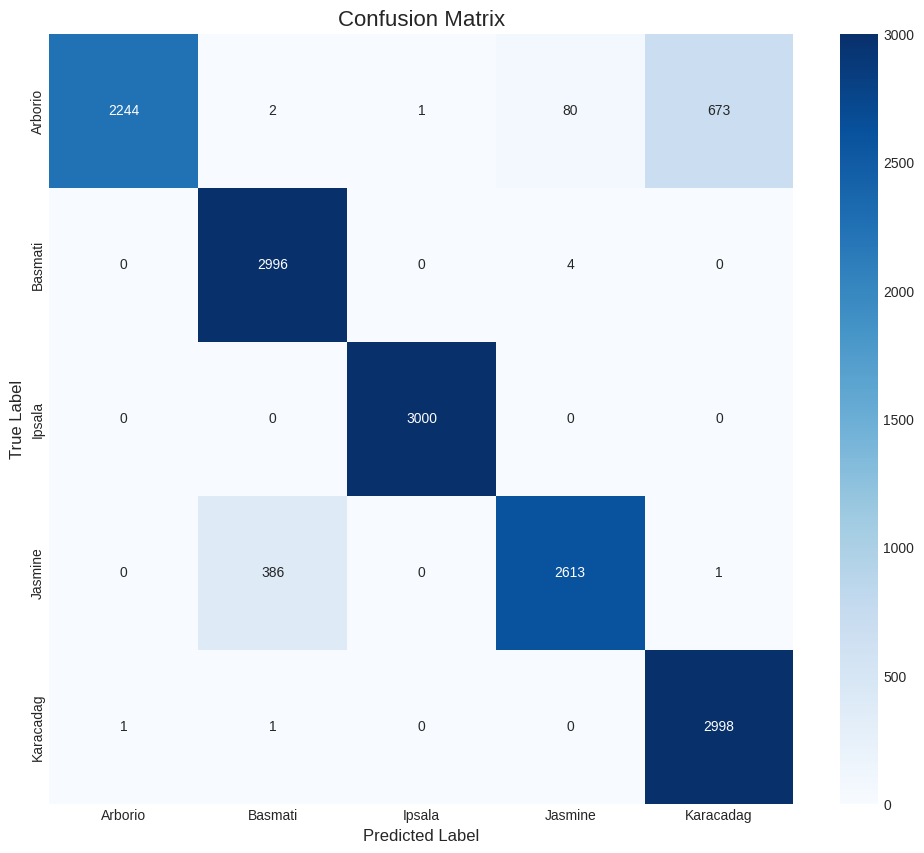

In [27]:
# Confusion Matrix 계산
cm = confusion_matrix(y_true_list, y_pred_list)

# Confusion Matrix 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()